In [1]:
# This class tests whether tensorflow and autograd both calculate the hessian-vector-products identically.

# The rosenbrock function is not a least squares optimization problem. 
# Additionally, I have formulated the loss function in such a way that to find a minimum, we need to 
# calculate the hessian-vector product.

In [2]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.autograd.curveball import Curveball as agCb
from sopt.optimizers.tensorflow.curveball import Curveball as tfCb

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def predict(x):
    x_reshaped = np.reshape(x, [2, -1])
    out1 = x_reshaped[1] - x_reshaped[0]**2
    out2 = 1 - x_reshaped[0]
    return np.array([out1, out2])
    
    
def rosenbrock(x):
    return np.sum(100*x[0]**2 + x[1]**2)

In [5]:
z_init = np.zeros(10)

In [6]:
# Autograd
cball_ag = agCb(z_init, predict, rosenbrock, squared_loss=False, damping_factor=10.)

In [7]:
ag_losses = [rosenbrock(predict(z_init))]
outs_all = []
for i in range(100):
    out = cball_ag.minimize()
    outs_all.append(out)
    lossval = rosenbrock(predict(out))
    ag_losses.append(lossval)

[[240.   0.]
 [  0.   0.]] [20.  0.] 0.08333333333333333 -0.0 -0.8333333333333333
[[3.63032730e+05 1.09386831e+03]
 [1.09386831e+03 4.75308642e+00]] [4.68415638e+02 1.54320988e-01] 0.003889789303079423 0.8627228525121572 -0.8444509474358217
[[2.99484076e+04 3.16331326e+01]
 [3.16331326e+01 1.10884945e+00]] [77.14470879 -0.77752025] 0.003419602819481953 0.7987495470014414 -0.4424241039863668
[[8.39609108e+03 4.80366674e+00]
 [4.80366674e+00 6.72109052e-01]] [21.40793764 -0.53925428] 0.003021143314611948 0.8239241004854084 -0.2544905227948728
[[5.05025668e+03 4.08059747e+00]
 [4.08059747e+00 4.46365495e-01]] [ 9.77461906 -0.36778298] 0.0026205770830553653 0.8479071713602475 -0.16873048610867952
[[3.02788632e+03 2.68583686e+00]
 [2.68583686e+00 3.14896438e-01]] [ 4.79258067 -0.26647117] 0.0023512269182855705 0.8662726949477293 -0.12105257343382046
[[1.87678798e+03 1.71862270e+00]
 [1.71862270e+00 2.32418742e-01]] [ 2.53122814 -0.20108556] 0.0021555717412757138 0.8811259185091534 -0.091318

In [8]:
# Tensorflow
tf.reset_default_graph()
tf_var = tf.Variable(z_init, dtype='float32')

def tf_predict_fn(x):
    x_reshaped = tf.reshape(x, [2, -1])
    out1 = x_reshaped[1] - x_reshaped[0]**2
    out2 = 1 - x_reshaped[0]
    return tf.stack([out1, out2])

def tf_rosenbrock(x):
    return tf.reduce_sum(100*x[0]**2 + x[1]**2)

tf_predictions_tensor = tf_predict_fn(tf_var)
tf_rosenbrock_tensor = tf_rosenbrock(tf_predictions_tensor)

cball_tf = tfCb(tf_var, tf_predict_fn, tf_rosenbrock, name='ros', damping_factor=10., damping_update_frequency=1, damping_update_factor=0.99)
minimizer = cball_tf.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [9]:
tf_losses = [session.run(tf_rosenbrock_tensor)]
for i in range(100):
    session.run(minimizer)
    lossval = session.run(tf_rosenbrock_tensor)
    #session.run(damping_update, feed_dict={placeholder:lossval})
    tf_losses.append(lossval)

[[240 0]
 [0 0]] [20 0] [0.0833333358 0] -0.833333373
[[363032.812 1093.86853]
 [1093.86853 4.75308657]] [468.41568 0.154321074] [0.00388978957 -0.862723172] -0.844451
[[29948.6484 31.633482]
 [31.633482 1.10885072]] [77.1452 -0.777519643] [0.00341960019 -0.798749089] -0.442424417
[[8392.42871 4.72361088]
 [4.72361088 0.666160464]] [21.4617367 -0.539254487] [0.00302496506 -0.83094579] -0.256506115
[[5488.47461 4.57806253]
 [4.57806253 0.446684301]] [10.4474754 -0.369539261] [0.00261595822 -0.854105] -0.17147775
[[3329.03784 2.95225072]
 [2.95225072 0.316847771]] [5.23932 -0.269329548] [0.00234703743 -0.871896863] -0.123562239
[[2104.90503 1.90013885]
 [1.90013885 0.234984398]] [2.83970547 -0.204006672] [0.00214848761 -0.88554436] -0.0933790132
[[1372.85266 1.23674524]
 [1.23674524 0.180251509]] [1.6318295 -0.159064323] [0.00199594744 -0.896152318] -0.0729014575
[[921.481506 0.822888136]
 [0.822888136 0.141904309]] [0.983148813 -0.126816332] [0.00187468668 -0.904546] -0.0582771525
[[634

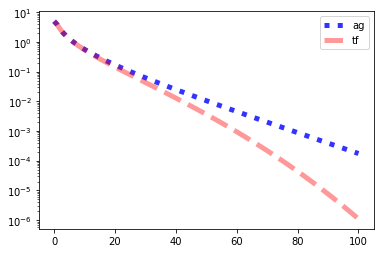

In [10]:
# The discrepancy here is because curveball requires a matrix inversion step
# the matrix becomes singular fairly often
# I tried calculating the pseudo inverse myself, but all the approach I tried for this 
# in tensorflow game solutions less stable and accurate than the numpy counterpart.
plt.plot(ag_losses, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag')
plt.plot(tf_losses, color='red', ls='--', linewidth=5.0, alpha=0.4, label='tf')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [11]:
# Solution is all ones
session.run(tf_var)

array([0.9995313 , 0.9995313 , 0.9995313 , 0.9995313 , 0.9995313 ,
       0.99906105, 0.99906105, 0.99906105, 0.99906105, 0.99906105],
      dtype=float32)